## Imports

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
IN_PATH = ".\inputs"
OUT_PATH = ".\outputs"

## Utility Functions

In [3]:
def find_dependence(graph, graph2, is_ancestor, evidence, node1, node2):
    path = [[node1, True]]
    dependent_nodes = [False] * len(graph)
    visited = [False] * (2 * len(graph))
    while len(path) != 0:
        node, direction = path.pop()
        if direction:
            visited_index = node + len(graph)
        else:
            visited_index = node
        if not visited[visited_index]:
            visited[visited_index] = True
            if evidence[node] == -1:
                dependent_nodes[node] = True
            else:
                dependent_nodes[node] = False
            if direction and evidence[node] == -1:
                for k in graph2[node]:
                    path.append([k, True])
                for k in graph[node]:
                    path.append([k, False])
            if not direction:
                if evidence[node] == -1:
                    for k in graph[node]:
                        path.append([k, False])
                if is_ancestor[node]:
                    for k in graph2[node]:
                        path.append([k, True])
    return dependent_nodes[node2]

In [4]:
def mult(cpt1, cpt2):
    cpt = []
    keys1 = cpt1[0].keys()
    keys2 = cpt2[0].keys()
    share_keys = []
    not_share_keys = []
    for key in keys1:
        if key in keys2 and key != 'Prob':
            share_keys.append(key)
        else:
            not_share_keys.append(key)
    for row1 in cpt1:
        for row2 in cpt2:
            flag = 1
            for key in share_keys:
                if row1[key] != row2[key]:
                    flag = 0
            if flag == 0:
                continue
            new_row = row2.copy()
            for key in not_share_keys:
                if key != 'Prob':
                    new_row[key] = row1[key]
                else:
                    new_row['Prob'] = row1['Prob'] * row2['Prob']
            cpt.append(new_row)
    return cpt

In [5]:
def find_joint(probability):
    cpt = probability[0]
    for i in range(1, len(probability)):
        cpt = mult(cpt, probability[i])
    return cpt

In [6]:
def elimination(joint, node):
    del_cpt = []
    id_tracker = {}
    for row2 in joint:
        row = row2.copy()
        id_string = ""
        for key in row.keys():
            if key == node or key == "Prob":
                continue
            if row[key]:
                id_string += "T"
            else:
                id_string += "F"
        if id_string in id_tracker.keys():
            id_tracker[id_string]['Prob'] += row['Prob']
        else:
            id_tracker[id_string] = row
    for key in id_tracker.keys():
        row = id_tracker[key]
        del row[node]
        del_cpt.append(row.copy())
    return del_cpt

In [7]:
def variable_elimination(evidence, nodes, probability, values):
    new_probability = probability
    for i in range(len(probability)):
        if i in nodes or evidence[i] != -1:
            continue
        after_joint_prob = []
        joint_prob = []
        for cpt in new_probability:
            if i in cpt[0].keys():
                joint_prob.append(cpt)
            else:
                after_joint_prob.append(cpt)
        joint = find_joint(joint_prob)
        new_probability = after_joint_prob
        new_probability.append(elimination(joint, i))
    final_joint = find_joint(new_probability)
    sum_prob = 0
    holder = 0
    for joint in final_joint:
        sum_prob += joint['Prob']
        flag = 1
        for k in range(len(nodes)):
            if joint[nodes[k]] != bool(values[k]):
                flag = 0
                break
        if flag == 1:
            holder = joint['Prob']
    return holder / sum_prob

In [8]:
def topological_sort_util(v, visited, stack, graph):
    visited[v] = True
    for i in graph[v]:
        if not visited[i]:
            topological_sort_util(i, visited, stack, graph)

    stack.append(v)

def topological_sort(graph):
    visited = [False] * len(graph)
    stack = []

    for i in range(len(graph)):
        if not visited[i]:
            topological_sort_util(i, visited, stack, graph)
    return stack[::-1]

In [9]:
def sample_vertex(node, father, values, sort_vertex, probability):
    cpt = probability[node]
    holder_row = {}
    for row in cpt:
        flag = 1
        for key in row.keys():
            if key != 'Prob' and values[key] != -1 and row[key] != values[key]:
                flag = 0
                break
        if flag == 1:
            holder_row = row.copy()
            break
    x = holder_row['Prob']
    random = np.random.random()
    if random < x:
        return True
    return False

In [10]:
def draw_plot(prior, reject, likelihood, gibbs, string_data, num):
    X = [1, 2, 3, 4, 5, 6, 7]

    # Plotting both the curves simultaneously
    plt.plot(X, prior, color='r', label='Prior')
    plt.plot(X, reject, color='g', label='Rejection')
    plt.plot(X, likelihood, color='b', label='Likelihood')
    plt.plot(X, gibbs, color='y', label='Gibbs')

    plt.xlabel("#Q")
    plt.ylabel("AE")
    plt.title(string_data)
    plt.legend()
    path = OUT_PATH
    path = os.path.join(path, str(num) + ".png")
    plt.savefig(path)
    plt.show()

## Real Value

In [11]:
def real_value(evidence, probability, nodes, values, graph3):
    new_probability = []
    for i in range(len(probability)):
        cpt = []
        for row in probability[i]:
            if row[i] != evidence[i] and evidence[i] != -1:
                continue
            flag = 1
            for j in graph3[i]:
                if row[j] != evidence[j] and evidence[j] != -1:
                    flag = 0
            if flag:
                cpt.append(row)
        new_probability.append(cpt)
    return variable_elimination(evidence.copy(), nodes, new_probability.copy(), values)

## 1. Prior Sampling

In [12]:
def prior_sample(evidence, nodes, values, probability, n, graph, graph2):
    sort_vertex = topological_sort(graph)
    samples = []
    for i in range(10000):
        value = [-1] * n
        for vertex in sort_vertex:
            value[vertex] = sample_vertex(vertex, graph2[vertex], value, sort_vertex, probability)
        flag = 1
        for j in range(len(evidence)):
            if evidence[j] != -1 and value[j] != evidence[j]:
                flag = 0
                break
        if flag == 1:
            samples.append(value)
    good_sample = 0
    for sample in samples:
        flag = 1
        for i in range(len(nodes)):
            if bool(values[i]) != sample[nodes[i]]:
                flag = 0
                break
        if flag == 1:
            good_sample += 1
    return good_sample / len(samples)

## 2. Rejection Sampling

In [13]:
def rejection_sample(evidence, nodes, values, probability, n, graph, graph2):
    sort_vertex = topological_sort(graph)
    samples = []
    for i in range(10000):
        value = [-1] * n
        flag = 1
        for vertex in sort_vertex:
            holder = sample_vertex(vertex, graph2[vertex], value, sort_vertex, probability)
            if evidence[vertex] != -1 and holder != evidence[vertex]:
                flag = 0
                break
            value[vertex] = holder
        if flag == 1:
            samples.append(value)
    good_sample = 0
    for sample in samples:
        flag = 1
        for i in range(len(nodes)):
            if bool(values[i]) != sample[nodes[i]]:
                flag = 0
                break
        if flag == 1:
            good_sample += 1
    return good_sample / len(samples)

## 3. Likelihood Sampling

In [14]:
def find_row(cpt, values):
    holder_row = {}
    for row in cpt:
        flag = 1
        for key in row.keys():
            if key != 'Prob' and values[key] != -1 and row[key] != values[key]:
                flag = 0
                break
        if flag == 1:
            holder_row = row.copy()
            break
    return holder_row['Prob']

In [15]:
def likelihood_sample(evidence, nodes, values, probability, n, graph, graph2):
    sort_vertex = topological_sort(graph)
    samples = []
    for i in range(10000):
        value = [-1] * n
        w = 1
        for vertex in sort_vertex:
            if evidence[vertex] == -1:
                value[vertex] = sample_vertex(vertex, graph2[vertex], value, sort_vertex, probability)
            else:
                value[vertex] = evidence[vertex]
                w *= find_row(probability[vertex], value)
        samples.append([value, w])
    good_sample = 0
    sum_sample = 0
    for sample in samples:
        flag = 1
        for i in range(len(nodes)):
            if bool(values[i]) != sample[0][nodes[i]]:
                flag = 0
                break
        sum_sample += sample[1]
        if flag == 1:
            good_sample += sample[1]
    return good_sample / sum_sample

## 4. Gibbs Sampling

In [16]:
def gibbs_sample(evidence, nodes, values, probability, n, graph, graph2):
    sort_vertex = topological_sort(graph)
    samples = []
    value = [-1] * n
    for i in range(n):
        if evidence[i] != -1:
            value[i] = evidence[i]
        else:
            if np.random.random() < 0.5:
                value[i] = True
            else:
                value[i] = False
    for i in range(10000):
        new_value = [-1] * n
        for vertex in sort_vertex:
            if evidence[vertex] == -1:
                value[vertex] = -1
                value[vertex] = sample_vertex(vertex, graph2[vertex], value, sort_vertex, probability)
                new_value[vertex] = value[vertex]
            else:
                new_value[vertex] = value[vertex]
        samples.append(new_value)
    good_sample = 0
    for sample in samples:
        flag = 1
        for i in range(len(nodes)):
            if bool(values[i]) != sample[nodes[i]]:
                flag = 0
                break
        if flag == 1:
            good_sample += 1
    return good_sample / len(samples)

## Execution

In [17]:
try:
    os.mkdir(OUT_PATH)
except OSError as error:
    print("File Already Exist!")

length = len([name for name in os.listdir(IN_PATH)])

File Already Exist!


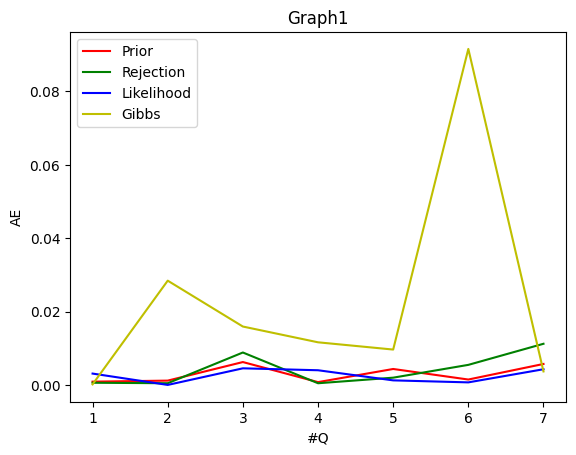

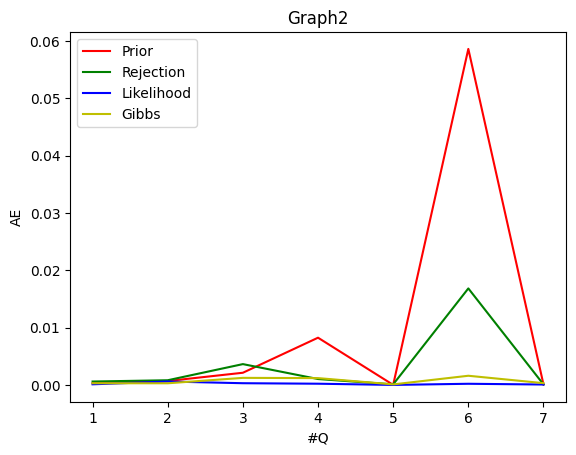

FileNotFoundError: [Errno 2] No such file or directory: '.\\inputs\\3\\input.txt'

In [18]:
for o in range(1, length + 1):
    path = os.path.join(IN_PATH, str(o) + "\input.txt")
    file = open(path, 'r')
    n = int(file.readline())
    names = {}
    probability = []
    graph3 = []
    graph2 = []
    graph1 = []
    for i in range(n):
        graph1.append([])
        graph2.append([])
        graph3.append([])
    for i in range(n):
        data = file.readline()
        data = data.strip('\n')
        data = data.rstrip()
        names[data] = i
        data = file.readline()
        data = data.strip('\n')
        data = data.rstrip()
        if 47 < ord(data[0]) < 58:
            cpt = []
            row = {i: True, 'Prob': float(data)}
            cpt.append(row)
            row = {i: False, 'Prob': 1 - float(data)}
            cpt.append(row)
            probability.append(cpt)
        else:
            parents = [x for x in data.split(" ")]
            for parent in parents:
                graph3[i].append(parent)
            cpt = []
            for j in range(2 ** (len(parents))):
                read = file.readline()
                read = read.strip('\n')
                read = read.rstrip()
                data = [float(x) for x in read.split(" ")]
                row = {i: True, 'Prob': data[len(data) - 1]}
                for k in range(len(parents)):
                    row[parents[k]] = bool(data[k])
                cpt.append(row)
                row2 = row.copy()
                row2[i] = False
                row2['Prob'] = 1 - row2["Prob"]
                cpt.append(row2)
            probability.append(cpt)

    for i in range(n):
        for node in graph3[i]:
            graph1[names[node]].append(i)
            graph2[i].append(names[node])

    new_probability = []
    for cpt in probability:
        new_cpt = []
        for row in cpt:
            new_row = {}
            for key in row.keys():
                if key in names.keys():
                    new_row[names[key]] = row[key]
                else:
                    new_row[key] = row[key]
            new_cpt.append(new_row)
        new_probability.append(new_cpt)

    file.close()

    path = os.path.join(IN_PATH, str(o) + "\q_input.txt")
    file = open(path, 'r')
    data = file.readline()
    x = json.loads(data)

    result_string = ""

    prior = []
    reject = []
    likelihood = []
    gibbs = []

    for query in x:
        node_data = query[0]
        evidence_data = query[1]
        evidence = [-1] * n
        nodes = []
        values = []
        for key in evidence_data.keys():
            evidence[names[key]] = bool(evidence_data[key])
        for key in node_data.keys():
            nodes.append(names[key])
            values.append(node_data[key])

        result_real = real_value(evidence, new_probability.copy(), nodes, values, graph2)
        result_prior_sample = prior_sample(evidence, nodes, values, new_probability, n, graph1, graph2)
        result_rejection_sample = rejection_sample(evidence, nodes, values, new_probability, n, graph1, graph2)
        result_likelihood_sample = likelihood_sample(evidence, nodes, values, new_probability, n, graph1, graph2)
        result_gibbs_sample = gibbs_sample(evidence, nodes, values, new_probability, n, graph1, graph2)

        ae_prior = abs(result_prior_sample - result_real)
        ae_rejection = abs(result_rejection_sample - result_real)
        ae_likelihood = abs(result_likelihood_sample - result_real)
        ae_gibbs = abs(result_gibbs_sample - result_real)

        result_string += str(result_real) + " " + str(ae_prior) + " " + str(ae_rejection) + " " + str(ae_likelihood) + " " + str(ae_gibbs) + "\n"

        prior.append(ae_prior)
        reject.append(ae_rejection)
        likelihood.append(ae_likelihood)
        gibbs.append(ae_gibbs)

    file.close()

    path = os.path.join(OUT_PATH, str(o) + ".txt")
    file = open(path, 'w')
    file.write(result_string)
    file.close()

    draw_plot(prior, reject, likelihood, gibbs, "Graph" + str(o), o)